# **Import Required Libraries:**


In [ ]:
import time
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load MNIST Dataset:**


## Dataset-1 for initial training

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

subset_digits = [0, 1, 2, 3, 4, 5, 6]
train_filter = np.isin(train_dataset.targets, subset_digits)
test_filter = np.isin(test_dataset.targets, subset_digits)

train_dataset.data = train_dataset.data[train_filter]
train_dataset.targets = train_dataset.targets[train_filter]
test_dataset.data = test_dataset.data[test_filter]
test_dataset.targets = test_dataset.targets[test_filter]


# Define the validation split size
validation_split = 0.2

# Calculate the number of samples for training and validation
num_train = len(train_dataset)
split = int(np.floor(validation_split * num_train))
indices = list(range(num_train))

# Shuffle the indices
np.random.shuffle(indices)

# Create the training and validation datasets
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the dataset
print("Train labels:", torch.unique(train_dataset.targets))
print("Test labels:", torch.unique(test_dataset.targets))


Train labels: tensor([0, 1, 2, 3, 4, 5, 6])
Test labels: tensor([0, 1, 2, 3, 4, 5, 6])


## Dataset-2 for Unlearning
### Class '6' to '7' and add new instances of class '7'

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_unlearn = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_unlearn = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a subset with classes 0-7
subset_digits = [0, 1, 2, 3, 4, 5, 6, 7]

train_filter = np.isin(train_dataset_unlearn.targets, subset_digits)
test_filter = np.isin(test_dataset_unlearn.targets, subset_digits)

train_dataset_unlearn.data = train_dataset_unlearn.data[train_filter]
train_dataset_unlearn.targets = train_dataset_unlearn.targets[train_filter]
test_dataset_unlearn.data = test_dataset_unlearn.data[test_filter]
test_dataset_unlearn.targets = test_dataset_unlearn.targets[test_filter]

# Change class 6 to class 7 in both training and testing datasets
train_dataset_unlearn.targets[train_dataset_unlearn.targets == 6] = 7
test_dataset_unlearn.targets[test_dataset_unlearn.targets == 6] = 7

# Create DataLoaders
train_loader_unlearn = torch.utils.data.DataLoader(dataset=train_dataset_unlearn, batch_size=64, shuffle=True)
test_loader_unlearn = torch.utils.data.DataLoader(dataset=test_dataset_unlearn, batch_size=64, shuffle=False)


# Define the validation split size
validation_split = 0.2

# Calculate the number of samples for training and validation
num_train = len(train_dataset_unlearn)
indices = list(range(num_train))
split = int(np.floor(validation_split * num_train))

# Shuffle the indices
np.random.shuffle(indices)

# Split indices for training and validation
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create DataLoaders for training, validation, and testing
train_loader_unlearn = torch.utils.data.DataLoader(train_dataset_unlearn, batch_size=64, sampler=train_sampler)
val_loader_unlearn = torch.utils.data.DataLoader(train_dataset_unlearn, batch_size=64, sampler=val_sampler)
test_loader_unlearn = torch.utils.data.DataLoader(test_dataset_unlearn, batch_size=64, shuffle=False)

# Verify the changes
print("Train labels after modification:", torch.unique(train_dataset_unlearn.targets))
print("Test labels after modification:", torch.unique(test_dataset_unlearn.targets))

Train labels after modification: tensor([0, 1, 2, 3, 4, 5, 7])
Test labels after modification: tensor([0, 1, 2, 3, 4, 5, 7])


# **Define the Model and Train it with initial Dataset-1**


## Create a CNN with 2 convolutional layers and 1 fully connected layer.

In [7]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        return x

## Training

In [12]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
summary(model, (1, 28, 28), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Linear-3                    [-1, 7]          21,959
Total params: 40,775
Trainable params: 40,775
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.16
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}%')
        model.train()

In [15]:
train(model, train_loader, val_loader, criterion, optimizer)

Epoch 1, Training Loss: 0.1448706661315546, Validation Loss: 0.03909154869324993, Accuracy: 98.70036961964946%
Epoch 2, Training Loss: 0.03324025028096955, Validation Loss: 0.044496926159781375, Accuracy: 98.40228925718374%
Epoch 3, Training Loss: 0.0241620695884783, Validation Loss: 0.031075414588444386, Accuracy: 98.89114105162751%
Epoch 4, Training Loss: 0.018751674898112903, Validation Loss: 0.02234815930348828, Accuracy: 99.28460713008226%
Epoch 5, Training Loss: 0.013857583950877944, Validation Loss: 0.021271382710851452, Accuracy: 99.24883748658638%


## Testing

Overall Accuracy: 99.34%
Accuracy of digit 0: 99.80%, correct predictions: 978.0, total predictions: 980.0
Accuracy of digit 1: 99.91%, correct predictions: 1134.0, total predictions: 1135.0
Accuracy of digit 2: 99.32%, correct predictions: 1025.0, total predictions: 1032.0
Accuracy of digit 3: 99.31%, correct predictions: 1003.0, total predictions: 1010.0
Accuracy of digit 4: 99.39%, correct predictions: 976.0, total predictions: 982.0
Accuracy of digit 5: 98.09%, correct predictions: 875.0, total predictions: 892.0
Accuracy of digit 6: 99.37%, correct predictions: 952.0, total predictions: 958.0


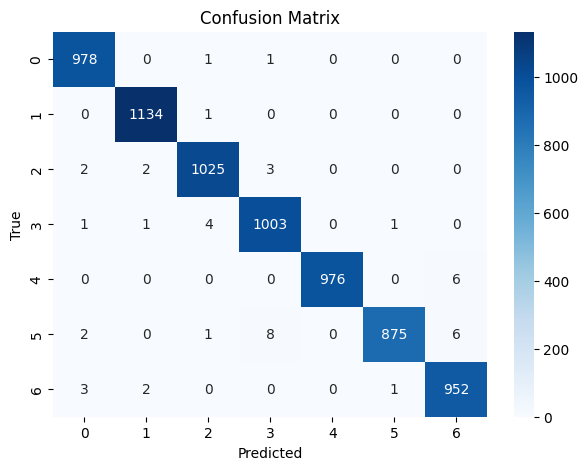

In [16]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    class_correct = list(0. for i in range(7))  # List to hold correct predictions for each class
    class_total = list(0. for i in range(7))    # List to hold total predictions for each class

    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collecting correct predictions for each class
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    for i in range(7):
        if class_total[i] != 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of digit {i}: {class_accuracy:.2f}%, correct predictions: {class_correct[i]}, total predictions: {class_total[i]}')
        else:
            print(f'No samples for digit {i}')

    # Compute and display the confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4, 5, 6])
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(7)), yticklabels=list(range(7)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



# test(model, test_loader)

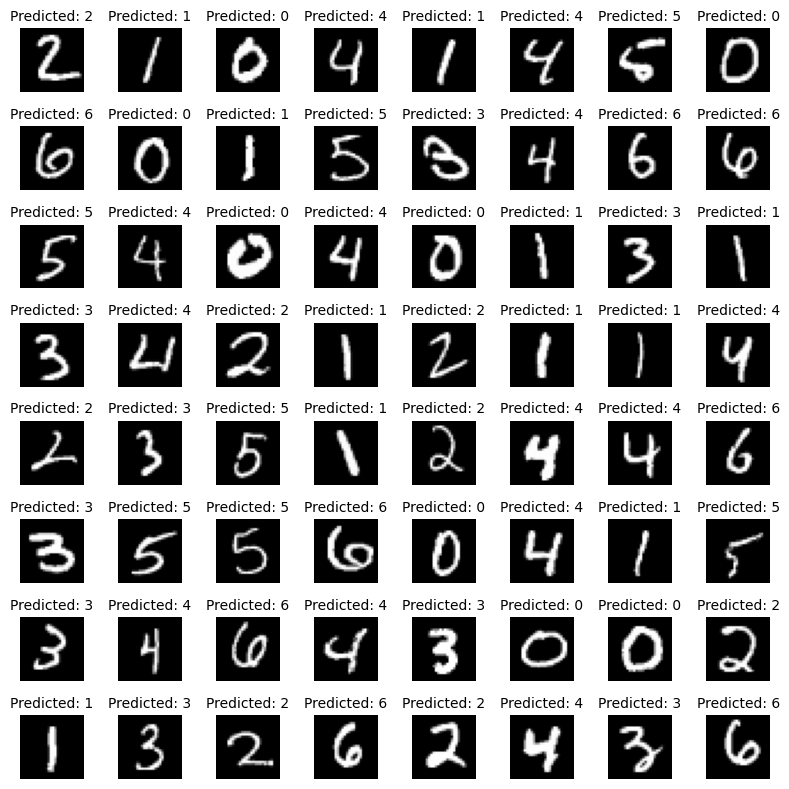

In [17]:
show_predictions=False

def show_batch(images, labels):
      plt.figure(figsize=(8, 8))
      for i in range(len(images)):
          plt.subplot(8, 8, i + 1)
          plt.imshow(images[i].numpy().squeeze(), cmap='gray')
          plt.title(f'Predicted: {labels[i].item()}',fontsize = 10)
          plt.axis('off')
      plt.tight_layout()
      plt.show()


if show_predictions:
  images, labels = next(iter(test_loader))

  model.eval()
  output = model(images)
  _, predicted = torch.max(output, 1)

  show_batch(images, predicted)
else:
  print('show_predictions assigned to False')

## Save/Load trained model weights

### Save weights

In [18]:
# Save the model weights
save=False
if save:
  torch.save(model.state_dict(), '/content/drive/MyDrive/DL/model_weights.pth')
  print("Model weights saved.")
else:
  print('Save assigned to False')

Save assigned to False


### Load weights and test it on test set

In [19]:
model = CNNModel()

model.load_state_dict(torch.load('/content/drive/MyDrive/DL/model_weights.pth'))
model.eval()  # Set the model to evaluation mode
print("Model weights loaded.")


Model weights loaded.


Overall Accuracy: 99.48%
Accuracy of digit 0: 99.59%, correct predictions: 976.0, total predictions: 980.0
Accuracy of digit 1: 100.00%, correct predictions: 1135.0, total predictions: 1135.0
Accuracy of digit 2: 99.32%, correct predictions: 1025.0, total predictions: 1032.0
Accuracy of digit 3: 99.90%, correct predictions: 1009.0, total predictions: 1010.0
Accuracy of digit 4: 99.80%, correct predictions: 980.0, total predictions: 982.0
Accuracy of digit 5: 98.54%, correct predictions: 879.0, total predictions: 892.0
Accuracy of digit 6: 99.06%, correct predictions: 949.0, total predictions: 958.0


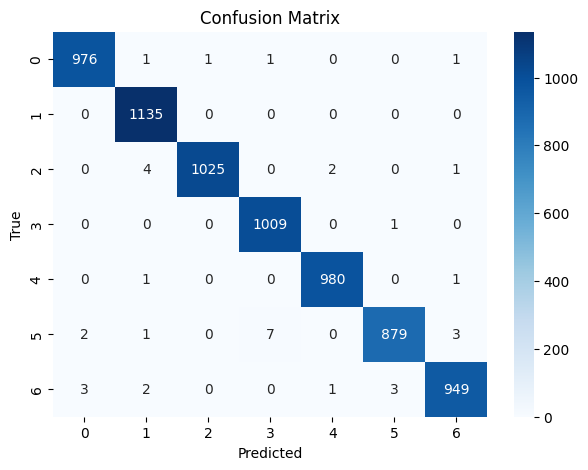

In [20]:
test(model, test_loader)

# **Unlearning (Solution 1): Baseline Approach**
### Using gradients to identify which weights are involved in predicting class '6':

In [21]:
def identify_significant_weights(model, train_loader, class_index=6, percentile=80):
    model.eval()
    param_gradients = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    count=0

    for images, labels in train_loader:
        mask = (labels == class_index)
        if mask.sum() == 0:
            continue
        count+=1

        # Forward pass
        output = model(images[mask])
        loss = criterion(output, labels[mask])

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Accumulate gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                param_gradients[name] += param.grad.abs()

    # Compute the mean gradients
    for name in param_gradients:
        param_gradients[name] /= count

    # Determine threshold for significant gradients
    all_gradients = torch.cat([g.view(-1) for g in param_gradients.values()])
    threshold = torch.quantile(all_gradients, percentile / 100.0).item()
    print('Threshold value: ',threshold)

    significant_weights = {name: (param.abs() <= threshold) for name, param in param_gradients.items()}
    return significant_weights

significant_weights = identify_significant_weights(model, train_loader, class_index=6)


Threshold value:  0.0002769762941170484


## Freeze insignificant weights based on the Threshold

In [22]:
def freeze_weights(model, significant_weights):
    for name, param in model.named_parameters():
      mask = significant_weights[name]
      if mask.any():  # Check if any weights are below the threshold
          param.requires_grad = False  # Freeze insignificant weights
          print(f'{name} are frozen')

freeze_weights(model, significant_weights)


conv2.weight are frozen
conv2.bias are frozen
fc1.weight are frozen
fc1.bias are frozen


## Retrain the Model with Modified Dataset-2

### Add an additional FC layer to the model to enable it to predict outputs for 8 classes (0-7)

In [51]:
class ExtendedCNNModel(nn.Module):
    def __init__(self, pretrained_model):
        super(ExtendedCNNModel, self).__init__()
        self.cnn = pretrained_model
        self.fc2 = nn.Linear(7, 8)  # Adding new fully connected layer with 8 outputs

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc2(x)
        return x
extended_model = ExtendedCNNModel(model)

In [52]:
summary(extended_model, (1,28,28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 14, 14]          18,496
            Linear-3                    [-1, 7]          21,959
          CNNModel-4                    [-1, 7]               0
            Linear-5                    [-1, 8]              64
Total params: 40,839
Trainable params: 384
Non-trainable params: 40,455
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 0.16
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


### Define custom loss penalising the class '6'

In [53]:
def custom_loss(output, target):
    base_loss = criterion(output, target)
    softmax = nn.Softmax(dim=1)
    probs = softmax(output)

    penalty = probs[:, 6].mean()  # Penalize for predicting class '6'
    return base_loss + 0.1 * penalty

### Training

In [54]:
optimizer = optim.Adam(extended_model.parameters(), lr=0.001)

In [55]:
def train_extended_model(model, train_loader, val_loader, optimizer, epochs=4):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images)
            loss = custom_loss(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                output = model(images)
                loss = custom_loss(output, labels)
                val_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss / len(val_loader)}, Accuracy: {accuracy}%')
        model.train()

In [56]:
# start timer
start_time = time.time()

train_extended_model(extended_model, train_loader_unlearn, val_loader_unlearn, optimizer)

# end timer
end_time = time.time()
total_time = end_time - start_time
print(f"Training time: {total_time:.2f} seconds")

Epoch 1, Training Loss: 0.8980769082459051, Validation Loss: 0.21583074494110827, Accuracy: 93.58921161825727%
Epoch 2, Training Loss: 0.13485164037761996, Validation Loss: 0.08674335596922612, Accuracy: 97.28215767634855%
Epoch 3, Training Loss: 0.07347837203625546, Validation Loss: 0.06612237234482703, Accuracy: 97.79045643153528%
Epoch 4, Training Loss: 0.06000717333517969, Validation Loss: 0.05768315618648039, Accuracy: 98.07053941908714%
Training time: 132.18 seconds


### Testing

In [57]:
def test_for_extended(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    class_correct = list(0. for i in range(8))  # List to hold correct predictions for each class
    class_total = list(0. for i in range(8))    # List to hold total predictions for each class
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in test_loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Collecting correct predictions for each class
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy}%')

    for i in range(8):
        if class_total[i] != 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Accuracy of digit {i}: {class_accuracy}%, correct predictions: {class_correct[i]}, total predictions: {class_total[i]}')
        else:
            print(f'No samples for digit {i}')
    print('\n\n')
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(8)), yticklabels=list(range(8)))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Overall Accuracy: 98.22876387676187%
Accuracy of digit 0: 99.18367346938776%, correct predictions: 972.0, total predictions: 980.0
Accuracy of digit 1: 99.20704845814979%, correct predictions: 1126.0, total predictions: 1135.0
Accuracy of digit 2: 98.44961240310077%, correct predictions: 1016.0, total predictions: 1032.0
Accuracy of digit 3: 98.61386138613861%, correct predictions: 996.0, total predictions: 1010.0
Accuracy of digit 4: 98.06517311608961%, correct predictions: 963.0, total predictions: 982.0
Accuracy of digit 5: 96.97309417040358%, correct predictions: 865.0, total predictions: 892.0
No samples for digit 6
Accuracy of digit 7: 97.53272910372608%, correct predictions: 1937.0, total predictions: 1986.0





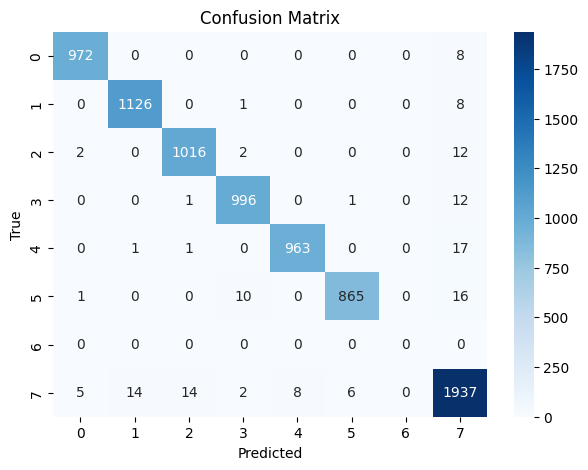

In [58]:
test_for_extended(extended_model, test_loader_unlearn)

### Save weights

In [59]:
# Save the model weights
save=False
if save:
  torch.save(extended_model.state_dict(), '/content/drive/MyDrive/DL/baseline_model_weights.pth')
  print("Model weights saved.")
else:
  print('Save assigned to False')

Model weights saved.


# **Unlearning (Solution 2): New Unlearning Procedure**


## Take a subset of MNIST dataset with only class '6'

In [60]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_new = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_new = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

digit_6_indices_train = train_dataset_new.targets == 6
train_dataset_new.data = train_dataset_new.data[digit_6_indices_train]
train_dataset_new.targets = train_dataset_new.targets[digit_6_indices_train]

digit_6_indices_test = test_dataset_new.targets == 6
test_dataset_new.data = test_dataset_new.data[digit_6_indices_test]
test_dataset_new.targets = test_dataset_new.targets[digit_6_indices_test]

train_loader_new = torch.utils.data.DataLoader(dataset=train_dataset_new, batch_size=64, shuffle=True)
test_loader_new = torch.utils.data.DataLoader(dataset=test_dataset_new, batch_size=64, shuffle=False)

# Verify the dataset
print("Train labels after modification:", torch.unique(train_dataset_new.targets))
print("Test labels after modification:", torch.unique(test_dataset_new.targets))

Train labels after modification: tensor([6])
Test labels after modification: tensor([6])


## Load pretrained model and initialize new one

In [92]:
new_model = CNNModel()

In [93]:
pretrained_model = CNNModel()

pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/DL/model_weights.pth'))
pretrained_model.eval()  # Set the model to evaluation mode
print("Model weights loaded.")

Model weights loaded.


## Train new model for class '6' only

In [94]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

In [95]:
train(new_model, train_loader_new, test_loader_new, criterion, optimizer, epochs=4)

Epoch 1, Training Loss: 0.03702572710666054, Validation Loss: 0.0, Accuracy: 100.0%
Epoch 2, Training Loss: 0.0, Validation Loss: 0.0, Accuracy: 100.0%
Epoch 3, Training Loss: 0.0, Validation Loss: 0.0, Accuracy: 100.0%
Epoch 4, Training Loss: 0.0, Validation Loss: 0.0, Accuracy: 100.0%


## Subtract the Weights

In [96]:
original_state_dict = pretrained_model.state_dict()
finetuned_state_dict = new_model.state_dict()

# Subtract the weights
for key in original_state_dict:
    original_state_dict[key] -= finetuned_state_dict[key]

# Load the updated state_dict back into the original model
pretrained_model.load_state_dict(original_state_dict)

<All keys matched successfully>

## Testing

Overall Accuracy: 89.01%
Accuracy of digit 0: 99.39%, correct predictions: 974.0, total predictions: 980.0
Accuracy of digit 1: 98.85%, correct predictions: 1122.0, total predictions: 1135.0
Accuracy of digit 2: 98.16%, correct predictions: 1013.0, total predictions: 1032.0
Accuracy of digit 3: 99.90%, correct predictions: 1009.0, total predictions: 1010.0
Accuracy of digit 4: 99.80%, correct predictions: 980.0, total predictions: 982.0
Accuracy of digit 5: 95.40%, correct predictions: 851.0, total predictions: 892.0
Accuracy of digit 6: 28.39%, correct predictions: 272.0, total predictions: 958.0


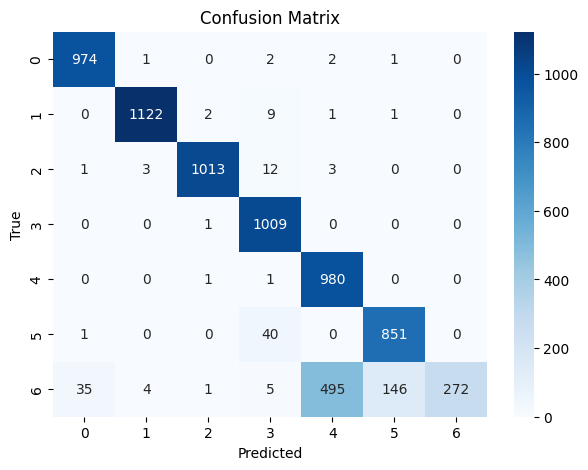

In [99]:
test(pretrained_model, test_loader)

## Save weights

In [ ]:
# Save the model weights
save=False
if save:
  torch.save(pretrained_model.state_dict(), '/content/drive/MyDrive/DL/new_approach_model_weights.pth')
  print("Model weights saved.")
else:
  print('Save assigned to False')

Model weights saved.


## Load weights

In [98]:
pretrained_model = CNNModel()
pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/DL/new_approach_model_weights.pth'))
pretrained_model.eval()  # Set the model to evaluation mode
print("Model weights loaded.")


Model weights loaded.


## Retrain the Model with Modified Dataset-2

In [102]:
extended_model_new = ExtendedCNNModel(pretrained_model)

In [103]:
optimizer = optim.Adam(extended_model_new.parameters(), lr=0.001)

In [104]:
start_time = time.time()

train_extended_model(extended_model_new, train_loader_unlearn, val_loader_unlearn, optimizer, epochs=4)

# end timer
end_time = time.time()
total_time = end_time - start_time
print(f"Training time: {total_time:.2f} seconds")

Epoch 1, Training Loss: 0.31770279672874097, Validation Loss: 0.06065247461372456, Accuracy: 98.20539419087137%
Epoch 2, Training Loss: 0.04948929643971231, Validation Loss: 0.04090032949642778, Accuracy: 98.67219917012449%
Epoch 3, Training Loss: 0.033690324681289775, Validation Loss: 0.03706904961064532, Accuracy: 98.81742738589212%
Epoch 4, Training Loss: 0.02578248106469099, Validation Loss: 0.040549214415881316, Accuracy: 98.81742738589212%
Training time: 154.76 seconds


## Testing

Overall Accuracy: 98.92727953099663%
Accuracy of digit 0: 99.6938775510204%, correct predictions: 977.0, total predictions: 980.0
Accuracy of digit 1: 99.8237885462555%, correct predictions: 1133.0, total predictions: 1135.0
Accuracy of digit 2: 98.93410852713178%, correct predictions: 1021.0, total predictions: 1032.0
Accuracy of digit 3: 98.51485148514851%, correct predictions: 995.0, total predictions: 1010.0
Accuracy of digit 4: 100.0%, correct predictions: 982.0, total predictions: 982.0
Accuracy of digit 5: 97.75784753363229%, correct predictions: 872.0, total predictions: 892.0
No samples for digit 6
Accuracy of digit 7: 98.23766364551864%, correct predictions: 1951.0, total predictions: 1986.0





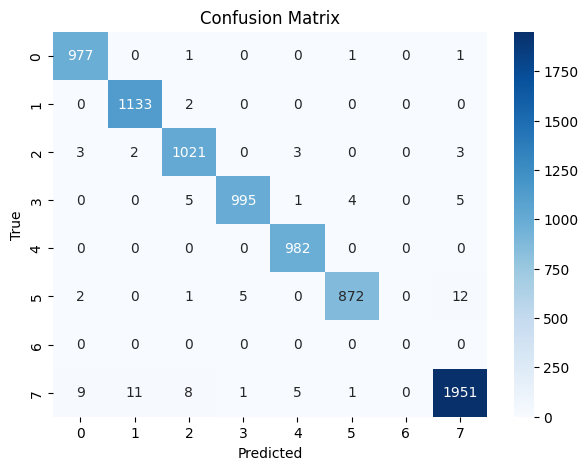

In [105]:
test_for_extended(extended_model_new, test_loader_unlearn)

# **Naive Approach for Comparision**
## Train model from scratch on classes 0, 1, 2, 3, 4, 5, 7

## Define the model

In [106]:
class naive_CNNModel(nn.Module):
    def __init__(self):
        super(naive_CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

## Training

In [107]:
naive_model = naive_CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(naive_model.parameters(), lr=0.001)


In [108]:
# start timer
start_time = time.time()

train(naive_model, train_loader_unlearn, val_loader_unlearn, criterion, optimizer)

# end timer
end_time = time.time()
total_time = end_time - start_time
print(f"Training time: {total_time:.2f} seconds")

Epoch 1, Training Loss: 0.1690886813064552, Validation Loss: 0.06092419846920876, Accuracy: 98.14315352697095%
Epoch 2, Training Loss: 0.04880016742472631, Validation Loss: 0.042364349791514905, Accuracy: 98.70331950207469%
Epoch 3, Training Loss: 0.033490088432089, Validation Loss: 0.04385115332679441, Accuracy: 98.78630705394191%
Epoch 4, Training Loss: 0.02684914739430839, Validation Loss: 0.04334503558903026, Accuracy: 98.7655601659751%
Epoch 5, Training Loss: 0.021041831349099524, Validation Loss: 0.03581318666076053, Accuracy: 98.99377593360995%
Training time: 201.04 seconds


## Testing

Overall Accuracy: 99.07696145690407%
Accuracy of digit 0: 99.59183673469387%, correct predictions: 976.0, total predictions: 980.0
Accuracy of digit 1: 99.38325991189427%, correct predictions: 1128.0, total predictions: 1135.0
Accuracy of digit 2: 97.86821705426357%, correct predictions: 1010.0, total predictions: 1032.0
Accuracy of digit 3: 99.60396039603961%, correct predictions: 1006.0, total predictions: 1010.0
Accuracy of digit 4: 99.4908350305499%, correct predictions: 977.0, total predictions: 982.0
Accuracy of digit 5: 98.4304932735426%, correct predictions: 878.0, total predictions: 892.0
No samples for digit 6
Accuracy of digit 7: 99.09365558912387%, correct predictions: 1968.0, total predictions: 1986.0





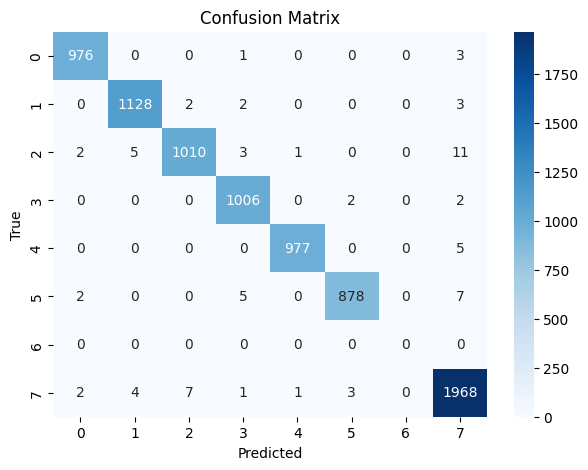

In [109]:
test_for_extended(naive_model, test_loader_unlearn)